In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomCrop(32, padding=4), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
batch_size = 64  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")


100%|██████████| 170M/170M [00:08<00:00, 20.9MB/s] 


Train dataset size: 50000
Test dataset size: 10000
Number of classes: 10


In [9]:
train_dataset, test_dataset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                ToTensor()
                Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                ToTensor()
                Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
            ))

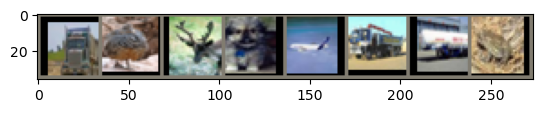

Labels: tensor([9, 2, 4, 5, 0, 9, 9, 6])


In [ ]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))
print(f"Labels: {labels[:8]}")


In [ ]:
class EfficientNetV2Model(nn.Module):
    def __init__(self, num_classes=100, input_channels=3):
        super(EfficientNetV2Model, self).__init__()
        self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        if input_channels != 3:
            self.model.features[0][0] = nn.Conv2d(input_channels, 24, kernel_size=3, stride=2, padding=1, bias=False)

        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

model = EfficientNetV2Model().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) 

def train_model(model, train_loader, test_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch {epoch+1}: Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

        test_acc = evaluate_model(model, test_loader)
        print(f"Test Accuracy: {test_acc:.2f}%\n")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

train_model(model, train_loader, test_loader, epochs=10)


Epoch 1: Loss: 1.1314, Train Acc: 62.56%


Test Accuracy: 77.78%



Epoch 2: Loss: 0.6534, Train Acc: 78.14%


Test Accuracy: 81.71%



Epoch 3: Loss: 0.6732, Train Acc: 77.55%


Test Accuracy: 76.38%



Epoch 4: Loss: 0.5868, Train Acc: 80.38%


Test Accuracy: 82.69%



Epoch 5: Loss: 0.4950, Train Acc: 83.55%


Test Accuracy: 84.02%



Epoch 6: Loss: 0.4568, Train Acc: 84.83%


Test Accuracy: 82.87%



Epoch 7: Loss: 0.4422, Train Acc: 85.20%


Test Accuracy: 83.00%



Epoch 8: Loss: 0.4500, Train Acc: 84.98%


Test Accuracy: 83.29%



Epoch 9: Loss: 0.3999, Train Acc: 86.57%


Test Accuracy: 84.86%



Epoch 10: Loss: 0.3885, Train Acc: 87.01%


Test Accuracy: 84.50%



In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import pandas as pd
from tqdm import tqdm
from itertools import product

os.makedirs("saved_models", exist_ok=True)

param_grid = {
    "learning_rate": [0.001, 0.0005, 0.0001],
    "batch_size": [32, 64, 128],
    "weight_decay": [0, 1e-4, 1e-3]
}

all_configs = list(product(param_grid["learning_rate"], param_grid["batch_size"], param_grid["weight_decay"]))
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

def train_model(model, train_loader, optimizer, criterion, epochs=7):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch {epoch+1}: Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

results = []

for i, (lr, batch_size, wd) in enumerate(all_configs):
    print(f"\nTraining Model {i+1}/27: LR={lr}, Batch Size={batch_size}, Weight Decay={wd}")
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 10)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()
    train_model(model, train_loader, optimizer, criterion, epochs=7)
    test_acc = evaluate_model(model, test_loader)
    print(f"Test Accuracy: {test_acc:.2f}%")
    model_path = f"saved_models/model_{i+1}_lr{lr}_bs{batch_size}_wd{wd}.pth"
    torch.save(model.state_dict(), model_path)

    results.append({"Model": i+1, "LR": lr, "Batch Size": batch_size, "Weight Decay": wd, "Test Accuracy": test_acc, "Model Path": model_path})

df = pd.DataFrame(results)
df.to_csv("hyperparameter_results.csv", index=False)

print("\n✅ Hyperparameter tuning complete! Results saved to 'hyperparameter_results.csv'")



Training Model 1/27: LR=0.001, Batch Size=32, Weight Decay=0


Epoch 1: Loss: 1.0888, Train Acc: 62.84%


Epoch 2: Loss: 0.7860, Train Acc: 74.11%


Epoch 3: Loss: 0.7487, Train Acc: 75.04%


Epoch 4: Loss: 0.7566, Train Acc: 75.05%


Epoch 5: Loss: 0.7191, Train Acc: 76.30%


Epoch 6: Loss: 0.6802, Train Acc: 77.47%


Epoch 7: Loss: 0.5583, Train Acc: 81.71%


Test Accuracy: 81.10%

Training Model 2/27: LR=0.001, Batch Size=32, Weight Decay=0.0001


Epoch 1: Loss: 1.1304, Train Acc: 60.98%


Epoch 2: Loss: 0.7597, Train Acc: 74.72%


Epoch 3: Loss: 0.7032, Train Acc: 76.49%


Epoch 4: Loss: 0.6433, Train Acc: 78.80%


Epoch 5: Loss: 0.5772, Train Acc: 81.05%


Epoch 6: Loss: 0.5438, Train Acc: 81.91%


Epoch 7: Loss: 0.5120, Train Acc: 82.89%


Test Accuracy: 82.80%

Training Model 3/27: LR=0.001, Batch Size=32, Weight Decay=0.001


Epoch 1: Loss: 1.0861, Train Acc: 63.02%


Epoch 2: Loss: 0.7746, Train Acc: 74.02%


Epoch 3: Loss: 0.7616, Train Acc: 74.15%


Epoch 4: Loss: 0.7873, Train Acc: 73.53%


Epoch 5: Loss: 0.7942, Train Acc: 72.75%


Epoch 6: Loss: 0.7779, Train Acc: 73.38%


Epoch 7: Loss: 0.7659, Train Acc: 73.76%


Test Accuracy: 74.10%

Training Model 4/27: LR=0.001, Batch Size=64, Weight Decay=0


Epoch 1: Loss: 0.9856, Train Acc: 66.16%


Epoch 2: Loss: 0.6227, Train Acc: 79.18%


Epoch 3: Loss: 0.5716, Train Acc: 81.10%


Epoch 4: Loss: 0.5037, Train Acc: 83.16%


Epoch 5: Loss: 0.4680, Train Acc: 84.43%


Epoch 6: Loss: 0.4369, Train Acc: 85.37%


Epoch 7: Loss: 0.4224, Train Acc: 86.00%


Test Accuracy: 85.81%

Training Model 5/27: LR=0.001, Batch Size=64, Weight Decay=0.0001


Epoch 1: Loss: 1.0238, Train Acc: 64.87%


Epoch 2: Loss: 0.6479, Train Acc: 78.09%


Epoch 3: Loss: 0.5531, Train Acc: 81.25%


Epoch 4: Loss: 0.5025, Train Acc: 83.13%


Epoch 5: Loss: 0.5075, Train Acc: 83.01%


Epoch 6: Loss: 0.4985, Train Acc: 83.30%


Epoch 7: Loss: 0.4320, Train Acc: 85.48%


Test Accuracy: 83.81%

Training Model 6/27: LR=0.001, Batch Size=64, Weight Decay=0.001


Epoch 1: Loss: 1.0634, Train Acc: 63.04%


Epoch 2: Loss: 0.6345, Train Acc: 78.48%


Epoch 3: Loss: 0.5539, Train Acc: 81.24%


Epoch 4: Loss: 0.5306, Train Acc: 81.96%


Epoch 5: Loss: 0.5334, Train Acc: 81.94%


Epoch 6: Loss: 0.5638, Train Acc: 81.05%


Epoch 7: Loss: 0.5892, Train Acc: 80.10%


Test Accuracy: 78.71%

Training Model 7/27: LR=0.001, Batch Size=128, Weight Decay=0


Epoch 1: Loss: 1.0806, Train Acc: 62.11%


Epoch 2: Loss: 0.6006, Train Acc: 79.36%


Epoch 3: Loss: 0.4839, Train Acc: 83.57%


Epoch 4: Loss: 0.4128, Train Acc: 86.11%


Epoch 5: Loss: 0.3759, Train Acc: 87.16%


Epoch 6: Loss: 0.3836, Train Acc: 87.09%


Epoch 7: Loss: 0.3276, Train Acc: 88.95%


Test Accuracy: 85.31%

Training Model 8/27: LR=0.001, Batch Size=128, Weight Decay=0.0001


Epoch 1: Loss: 1.0231, Train Acc: 64.40%


Epoch 2: Loss: 0.5665, Train Acc: 80.82%


Epoch 3: Loss: 0.4629, Train Acc: 84.27%


Epoch 4: Loss: 0.4068, Train Acc: 86.26%


Epoch 5: Loss: 0.3792, Train Acc: 87.21%


Epoch 6: Loss: 0.3532, Train Acc: 88.07%


Epoch 7: Loss: 0.3393, Train Acc: 88.47%


Test Accuracy: 86.96%

Training Model 9/27: LR=0.001, Batch Size=128, Weight Decay=0.001


Epoch 1: Loss: 1.0385, Train Acc: 64.15%


Epoch 2: Loss: 0.5959, Train Acc: 80.02%


Epoch 3: Loss: 0.5069, Train Acc: 82.76%


Epoch 4: Loss: 0.4839, Train Acc: 83.58%


Epoch 5: Loss: 0.4719, Train Acc: 83.95%


Epoch 6: Loss: 0.4721, Train Acc: 83.93%


Epoch 7: Loss: 0.4801, Train Acc: 83.79%


Test Accuracy: 79.77%

Training Model 10/27: LR=0.0005, Batch Size=32, Weight Decay=0


Epoch 1: Loss: 1.1085, Train Acc: 61.75%


Epoch 2: Loss: 0.6870, Train Acc: 77.03%


Epoch 3: Loss: 0.5869, Train Acc: 80.39%


Epoch 4: Loss: 0.5350, Train Acc: 82.33%


Epoch 5: Loss: 0.4866, Train Acc: 83.64%


Epoch 6: Loss: 0.4533, Train Acc: 84.81%


Epoch 7: Loss: 0.4190, Train Acc: 86.15%


Test Accuracy: 84.79%

Training Model 11/27: LR=0.0005, Batch Size=32, Weight Decay=0.0001


Epoch 1: Loss: 1.1123, Train Acc: 61.68%


Epoch 2: Loss: 0.6911, Train Acc: 77.08%


Epoch 3: Loss: 0.5875, Train Acc: 80.45%


Epoch 4: Loss: 0.5235, Train Acc: 82.54%


Epoch 5: Loss: 0.4883, Train Acc: 83.67%


Epoch 6: Loss: 0.4631, Train Acc: 84.41%


Epoch 7: Loss: 0.4315, Train Acc: 85.44%


Test Accuracy: 85.22%

Training Model 12/27: LR=0.0005, Batch Size=32, Weight Decay=0.001


Epoch 1: Loss: 1.1329, Train Acc: 60.93%


Epoch 2: Loss: 0.6851, Train Acc: 76.73%


Epoch 3: Loss: 0.5973, Train Acc: 79.76%


Epoch 4: Loss: 0.5683, Train Acc: 80.84%


Epoch 5: Loss: 0.5683, Train Acc: 80.76%


Epoch 6: Loss: 0.5688, Train Acc: 80.74%


Epoch 7: Loss: 0.5825, Train Acc: 80.32%


Test Accuracy: 79.72%

Training Model 13/27: LR=0.0005, Batch Size=64, Weight Decay=0


Epoch 1: Loss: 1.1141, Train Acc: 61.18%


Epoch 2: Loss: 0.6424, Train Acc: 78.39%


Epoch 3: Loss: 0.5133, Train Acc: 82.71%


Epoch 4: Loss: 0.4592, Train Acc: 84.55%


Epoch 5: Loss: 0.4125, Train Acc: 85.98%


Epoch 6: Loss: 0.3750, Train Acc: 87.43%


Epoch 7: Loss: 0.3612, Train Acc: 87.83%


Test Accuracy: 86.31%

Training Model 14/27: LR=0.0005, Batch Size=64, Weight Decay=0.0001


Epoch 1: Loss: 1.0974, Train Acc: 61.96%


Epoch 2: Loss: 0.6308, Train Acc: 78.44%


Epoch 3: Loss: 0.5033, Train Acc: 83.04%


Epoch 4: Loss: 0.4414, Train Acc: 85.21%


Epoch 5: Loss: 0.3986, Train Acc: 86.28%


Epoch 6: Loss: 0.3744, Train Acc: 87.19%


Epoch 7: Loss: 0.3511, Train Acc: 87.96%


Test Accuracy: 84.94%

Training Model 15/27: LR=0.0005, Batch Size=64, Weight Decay=0.001


Epoch 1: Loss: 1.0910, Train Acc: 62.35%


Epoch 2: Loss: 0.6760, Train Acc: 77.03%


Epoch 3: Loss: 0.5607, Train Acc: 80.78%


Epoch 4: Loss: 0.5361, Train Acc: 81.66%


Epoch 5: Loss: 0.4685, Train Acc: 83.91%


Epoch 6: Loss: 0.4474, Train Acc: 84.69%


Epoch 7: Loss: 0.4437, Train Acc: 84.82%


Test Accuracy: 82.83%

Training Model 16/27: LR=0.0005, Batch Size=128, Weight Decay=0


Epoch 1: Loss: 1.1030, Train Acc: 60.95%


Epoch 2: Loss: 0.6132, Train Acc: 78.98%


Epoch 3: Loss: 0.4708, Train Acc: 83.88%


Epoch 4: Loss: 0.3990, Train Acc: 86.39%


Epoch 5: Loss: 0.3496, Train Acc: 88.04%


Epoch 6: Loss: 0.3173, Train Acc: 89.13%


Epoch 7: Loss: 0.2849, Train Acc: 90.10%


Test Accuracy: 87.30%

Training Model 17/27: LR=0.0005, Batch Size=128, Weight Decay=0.0001


Epoch 1: Loss: 1.1170, Train Acc: 60.71%


Epoch 2: Loss: 0.6045, Train Acc: 79.31%


Epoch 3: Loss: 0.4705, Train Acc: 83.89%


Epoch 4: Loss: 0.4000, Train Acc: 86.24%


Epoch 5: Loss: 0.3483, Train Acc: 88.27%


Epoch 6: Loss: 0.3123, Train Acc: 89.31%


Epoch 7: Loss: 0.2925, Train Acc: 89.98%


Test Accuracy: 87.28%

Training Model 18/27: LR=0.0005, Batch Size=128, Weight Decay=0.001


Epoch 1: Loss: 1.1154, Train Acc: 60.95%


Epoch 2: Loss: 0.6136, Train Acc: 79.02%


Epoch 3: Loss: 0.4854, Train Acc: 83.39%


Epoch 4: Loss: 0.4354, Train Acc: 85.25%


Epoch 5: Loss: 0.3933, Train Acc: 86.65%


Epoch 6: Loss: 0.3712, Train Acc: 87.21%


Epoch 7: Loss: 0.3575, Train Acc: 87.54%


Test Accuracy: 85.11%

Training Model 19/27: LR=0.0001, Batch Size=32, Weight Decay=0


Epoch 1: Loss: 1.5951, Train Acc: 42.52%


Epoch 2: Loss: 1.0148, Train Acc: 64.54%


Epoch 3: Loss: 0.8167, Train Acc: 71.96%


Epoch 4: Loss: 0.6757, Train Acc: 76.64%


Epoch 5: Loss: 0.5770, Train Acc: 80.34%


Epoch 6: Loss: 0.4954, Train Acc: 82.85%


Epoch 7: Loss: 0.4362, Train Acc: 85.12%


Test Accuracy: 85.90%

Training Model 20/27: LR=0.0001, Batch Size=32, Weight Decay=0.0001


Epoch 1: Loss: 1.6016, Train Acc: 42.70%


Epoch 2: Loss: 1.0390, Train Acc: 63.91%


Epoch 3: Loss: 0.8347, Train Acc: 71.01%


Epoch 4: Loss: 0.6912, Train Acc: 76.23%


Epoch 5: Loss: 0.5878, Train Acc: 79.74%


Epoch 6: Loss: 0.5067, Train Acc: 82.75%


Epoch 7: Loss: 0.4443, Train Acc: 84.61%


Test Accuracy: 85.98%

Training Model 21/27: LR=0.0001, Batch Size=32, Weight Decay=0.001


Epoch 1: Loss: 1.6181, Train Acc: 41.74%


Epoch 2: Loss: 1.0466, Train Acc: 63.39%


Epoch 3: Loss: 0.8354, Train Acc: 71.09%


Epoch 4: Loss: 0.6930, Train Acc: 76.05%


Epoch 5: Loss: 0.5890, Train Acc: 79.82%


Epoch 6: Loss: 0.5127, Train Acc: 82.42%


Epoch 7: Loss: 0.4471, Train Acc: 84.76%


Test Accuracy: 85.80%

Training Model 22/27: LR=0.0001, Batch Size=64, Weight Decay=0


Epoch 1: Loss: 1.6795, Train Acc: 39.46%


Epoch 2: Loss: 1.0913, Train Acc: 61.61%


Epoch 3: Loss: 0.8936, Train Acc: 68.88%


Epoch 4: Loss: 0.7592, Train Acc: 73.60%


Epoch 5: Loss: 0.6657, Train Acc: 76.97%


Epoch 6: Loss: 0.5777, Train Acc: 79.66%


Epoch 7: Loss: 0.5160, Train Acc: 82.05%


Test Accuracy: 82.31%

Training Model 23/27: LR=0.0001, Batch Size=64, Weight Decay=0.0001


Epoch 1: Loss: 1.6477, Train Acc: 40.53%


Epoch 2: Loss: 1.0461, Train Acc: 63.32%


Epoch 3: Loss: 0.8518, Train Acc: 70.35%


Epoch 4: Loss: 0.7206, Train Acc: 75.00%


Epoch 5: Loss: 0.6245, Train Acc: 78.32%


Epoch 6: Loss: 0.5447, Train Acc: 81.07%


Epoch 7: Loss: 0.4851, Train Acc: 83.10%


Test Accuracy: 83.43%

Training Model 24/27: LR=0.0001, Batch Size=64, Weight Decay=0.001


Epoch 1: Loss: 1.6597, Train Acc: 39.77%


Epoch 2: Loss: 1.0481, Train Acc: 63.40%


Epoch 3: Loss: 0.8395, Train Acc: 71.02%


Epoch 4: Loss: 0.7188, Train Acc: 75.10%


Epoch 5: Loss: 0.6220, Train Acc: 78.43%


Epoch 6: Loss: 0.5471, Train Acc: 80.90%


Epoch 7: Loss: 0.4801, Train Acc: 83.31%


Test Accuracy: 83.93%

Training Model 25/27: LR=0.0001, Batch Size=128, Weight Decay=0


Epoch 1: Loss: 1.8084, Train Acc: 34.71%


Epoch 2: Loss: 1.1570, Train Acc: 59.19%


Epoch 3: Loss: 0.9460, Train Acc: 66.98%


Epoch 4: Loss: 0.8156, Train Acc: 71.42%


Epoch 5: Loss: 0.7209, Train Acc: 74.77%


Epoch 6: Loss: 0.6377, Train Acc: 77.79%


Epoch 7: Loss: 0.5809, Train Acc: 79.62%


Test Accuracy: 79.86%

Training Model 26/27: LR=0.0001, Batch Size=128, Weight Decay=0.0001


Epoch 1: Loss: 1.7608, Train Acc: 36.57%


Epoch 2: Loss: 1.1090, Train Acc: 61.14%


Epoch 3: Loss: 0.8976, Train Acc: 68.65%


Epoch 4: Loss: 0.7696, Train Acc: 73.17%


Epoch 5: Loss: 0.6756, Train Acc: 76.50%


Epoch 6: Loss: 0.6041, Train Acc: 78.91%


Epoch 7: Loss: 0.5411, Train Acc: 81.20%


Test Accuracy: 80.43%

Training Model 27/27: LR=0.0001, Batch Size=128, Weight Decay=0.001


Epoch 1: Loss: 1.7795, Train Acc: 35.81%


Epoch 2: Loss: 1.1324, Train Acc: 60.27%


Epoch 3: Loss: 0.9229, Train Acc: 67.69%


Epoch 4: Loss: 0.7919, Train Acc: 72.49%


Epoch 5: Loss: 0.6967, Train Acc: 75.66%


Epoch 6: Loss: 0.6280, Train Acc: 78.11%


Epoch 7: Loss: 0.5686, Train Acc: 80.09%


Test Accuracy: 80.52%

✅ Hyperparameter tuning complete! Results saved to 'hyperparameter_results.csv'


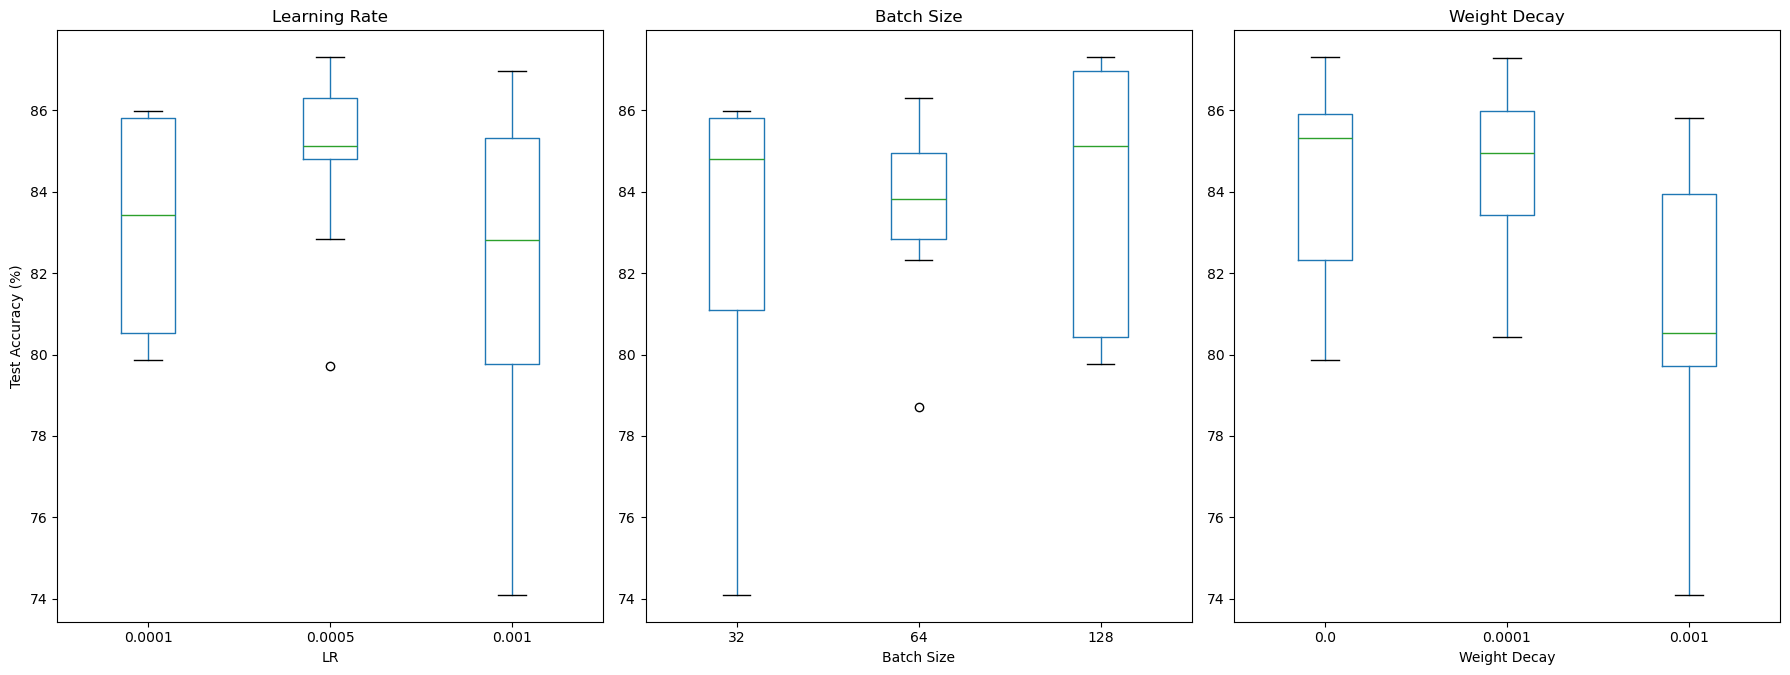

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("hyperparameter_results.csv")

fig, axes = plt.subplots(1, 3, figsize=(18, 7))
fig.suptitle("Test Accuracy Distributions by Hyperparameter", fontsize=16)

df.boxplot(column="Test Accuracy", by="LR", ax=axes[0])
axes[0].set_title("Learning Rate")
axes[0].set_xlabel("LR")
axes[0].set_ylabel("Test Accuracy (%)")
axes[0].grid(False)

df.boxplot(column="Test Accuracy", by="Batch Size", ax=axes[1])
axes[1].set_title("Batch Size")
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("")
axes[1].grid(False)

df.boxplot(column="Test Accuracy", by="Weight Decay", ax=axes[2])
axes[2].set_title("Weight Decay")
axes[2].set_xlabel("Weight Decay")
axes[2].set_ylabel("")
axes[2].grid(False)

plt.suptitle("")  
plt.tight_layout()
plt.show()


In [37]:
best = df['Test Accuracy'].idxmax()
df.iloc[best]

Model                                                      16
LR                                                     0.0005
Batch Size                                                128
Weight Decay                                              0.0
Test Accuracy                                            87.3
Model Path       saved_models/model_16_lr0.0005_bs128_wd0.pth
Name: 15, dtype: object